In [4]:
# Task: Predict montly average sunspot number

# Highlights:
# hightly seasonal data
# 1. tf.data.Dataset
# 2. Conv1d + lstm network with sigmoid
# lr scheduler and model checkpoints


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# function to plot series

def plot_series(x,y,format="-",start=0, end=None,
                title=None, xlabel =None, ylabel=None, legend=None):
    

    plt.figure(figsize=(10,6))

    if type(y) is tuple:

        for yi in y:
            plt.plot(x[start:end],yi[start:end],format)
        
    else:
        plt.plot(x[start:end],y[start:end],format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if legend:
        plt.legend(legend)
    
    plt.title(title)
    plt.grid(True)
    
    plt.show()


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/gouravsinghbais/Time-Series-Forecasting-with-Tensorflow-and-InfluxDB/master/sunspots-dataset/Sunspots.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [9]:
df.head()

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7


<Axes: xlabel='Date'>

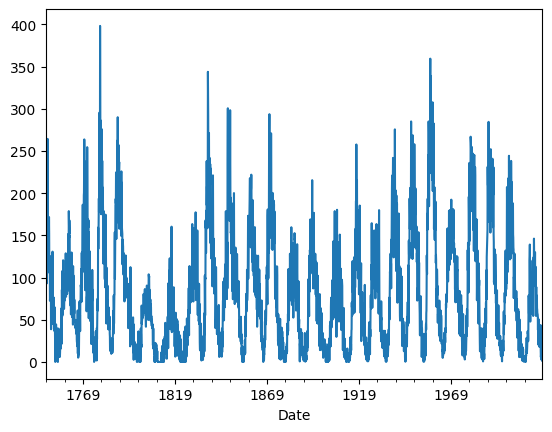

In [10]:
 df['Monthly Mean Total Sunspot Number'].plot()

In [11]:
time = df.index.to_numpy()
series = df['Monthly Mean Total Sunspot Number'].to_numpy()

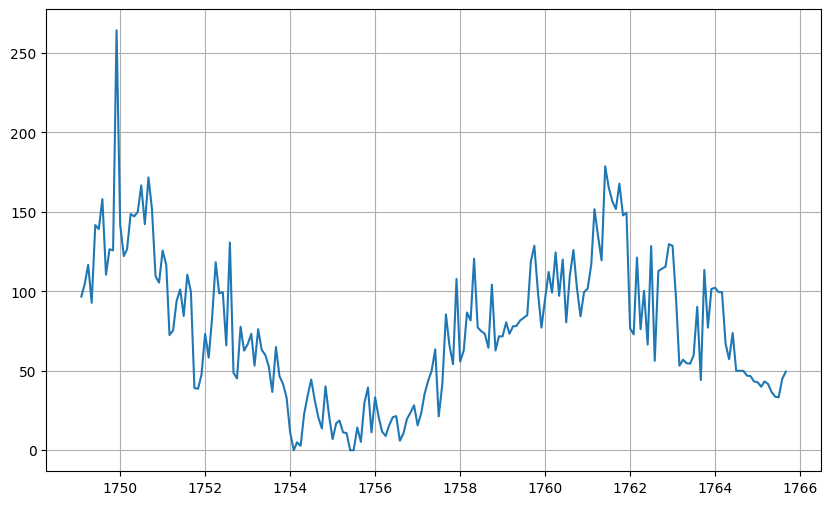

In [16]:
plot_series(time,series,start=0,end=200)

In [19]:
# Time series split
split_time = int(0.8 * len(series))

# train set
time_train = time[:split_time]
x_train = series[:split_time]

# validation set
time_val = time[split_time:]
x_val = series[split_time:]

In [20]:
# Prepare features and Labels

def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
    # Creating tf dataset 
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # windowed dataset
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

    # flatten window by putting its element in a single batach
    dataset = dataset.flat_map(lambda window: window.batch(window_size +1))
    
    # create features and tuples
    dataset = dataset.map(lambda window: (window[:-1],window[-1]))

    # shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # create batch of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [21]:
# Defining parameters

window_size = 30
batch_size = 32
shuffle_buffer_size=1000

In [22]:
# train set
train_data = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [60]:
# Define model
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                           strides=1,
                           activation='sigmoid',
                           input_shape=[window_size,1]),
    tf.keras.layers.LSTM(128,return_sequences=True,activation='sigmoid'),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
],name="sunspots_lstm")

model.summary()

C:\Users\Shruti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sunspots_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 28, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,461 (587.74 KB)

 Trainable params: 150,461 (587.74 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# tune in learning rate
lr_scheduler = tf.keras.callbacks.LearningRateScheduler( 
    lambda epoch : 1e-8 * 10**(epoch/20)
)

import os
def create_modelcheckpoint(modelname, save_path = "model"):

    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,modelname,'.keras'), monitor='val_loss',verbose=0,save_best_only=True)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer=optimizer)

history = model.fit(train_data,
                    epochs=100,
                    verbose=0,
                    callbacks=[lr_scheduler,create_modelcheckpoint(modelname=model.name)])

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
C:\Users\Shruti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


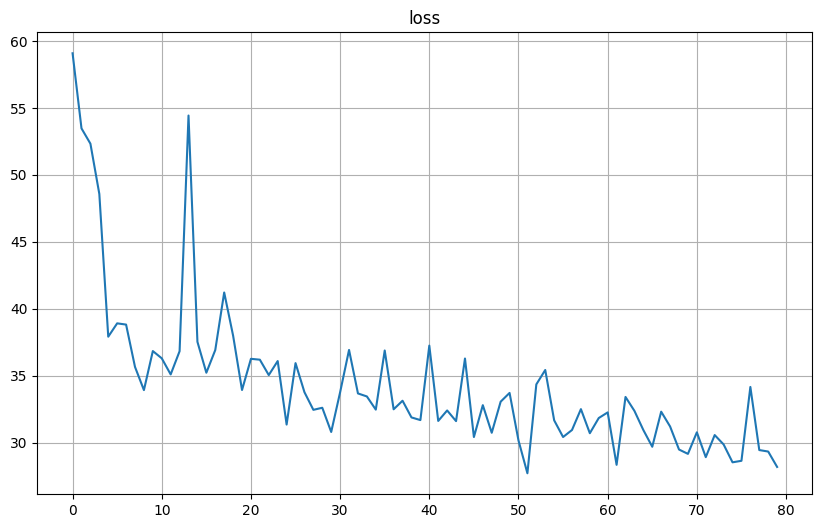

In [65]:
# lr = np.log(history.history['learning_rate'])
loss = history.history['loss']

epochs = range(len(loss))

plot_series(epochs,(loss),title='loss')

In [64]:
lr = (history.history['learning_rate'])

epochs = range(len(lr))

plot_series(epochs,(lr),title='lr')

KeyError: 'learning_rate'

In [61]:
tf.keras.backend.clear_session()

optimizer = tf.keras.optimizers.SGD(momentum=0.9,learning_rate=0.0001)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer=optimizer)

history = model.fit(train_data,
                    epochs=80,
                    verbose=0,
                    callbacks=[create_modelcheckpoint(modelname=model.name)])

C:\Users\Shruti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


In [51]:
def model_prediction(model,series,window_size,batch_size):

    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size,shift=1,drop_remainder=True)

    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    dataset = dataset.batch(batch_size).prefetch(1)

    forecast = model.predict(dataset)

    return forecast

In [62]:
forecast_series = series[split_time-window_size:-1]

forecast = model_prediction(model,forecast_series,window_size,batch_size)

results = forecast.squeeze()



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


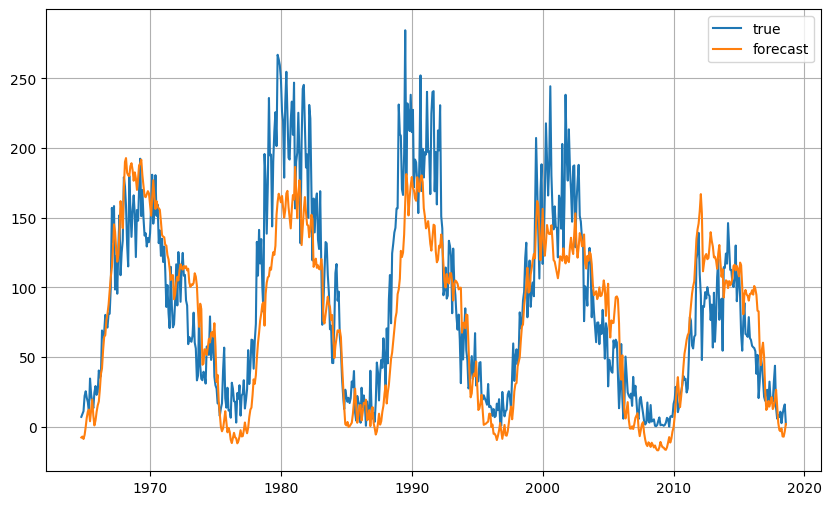

In [63]:
plot_series(time_val,(x_val,results),legend=['true','forecast'])

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


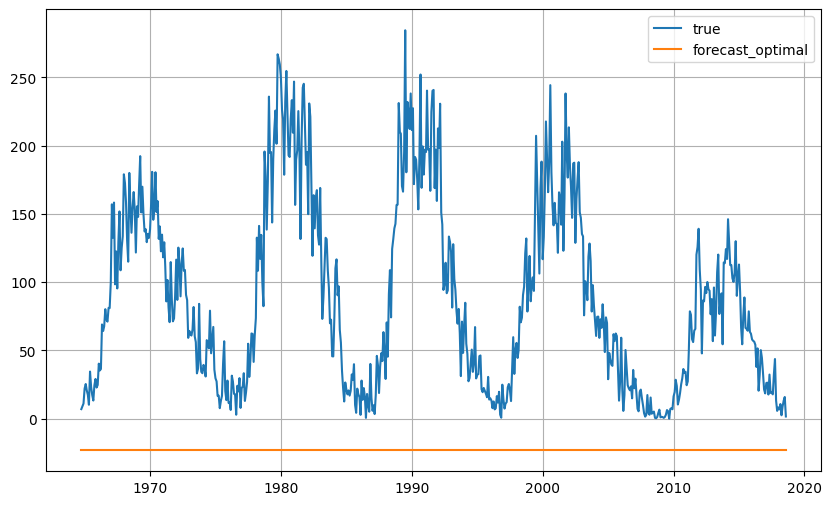

In [59]:
forecast2 = model_prediction(model,forecast_series,window_size,batch_size)

results2 = forecast.squeeze()
plot_series(time_val,(x_val,results2),legend=['true','forecast_optimal'])